In [1]:
# 导入核心库
import numpy as np
import matplotlib.pyplot as plt
import os
import urllib.request # 用于下载数据集

# 导入 sklearn 中需要的模块
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# 设置 matplotlib 在 notebook 中内嵌显示图像
%matplotlib inline

Matplotlib is building the font cache; this may take a moment.


In [2]:
# --- 1. 数据准备 ---

# 数据集URL和本地文件名
data_url = "https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/housing"
data_file = "housing"

# 检查文件是否存在，如果不存在则下载
if not os.path.exists(data_file):
    print("正在下载数据集...")
    urllib.request.urlretrieve(data_url, data_file)
    print("下载完成。")

# 使用 load_svmlight_file 读取数据
# X_sparse 是一个稀疏矩阵, y 是标签 (房价)
X_sparse, y = load_svmlight_file(data_file)

# 将稀疏矩阵转换为密集的 numpy 数组
X = X_sparse.toarray()

# 将 y 转换为一个 "列向量" (n_samples, 1)，这在后续矩阵运算中更方便
y = y.reshape(-1, 1)

print(f"数据加载完成。 X的形状: {X.shape}, y的形状: {y.shape}")
print(f"总样本数: {X.shape[0]}, 特征数: {X.shape[1]}")

正在下载数据集...
下载完成。
数据加载完成。 X的形状: (506, 13), y的形状: (506, 1)
总样本数: 506, 特征数: 13


In [3]:
# --- 1.2 切分数据集 ---
# test_size=0.2 表示 20% 的数据作为测试集
# random_state=42 是为了保证每次切分的结果都一样，便于复现
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"训练集: X_train.shape = {X_train.shape}, y_train.shape = {y_train.shape}")
print(f"验证集: X_val.shape = {X_val.shape}, y_val.shape = {y_val.shape}")

训练集: X_train.shape = (404, 13), y_train.shape = (404, 1)
验证集: X_val.shape = (102, 13), y_val.shape = (102, 1)


In [4]:
# --- 1.3 特征标准化 ---
scaler = StandardScaler()

# 1. 在训练集上计算均值和标准差，并转换 X_train
X_train_scaled = scaler.fit_transform(X_train)

# 2. 使用训练集的均值和标准差来转换验证集
X_val_scaled = scaler.transform(X_val)

print("数据标准化完成。")

数据标准化完成。


In [5]:
# --- 2. 线性回归的闭式解 ---

# 2.1 为 X_train_scaled 和 X_val_scaled 添加偏置列 (一列 1)
# np.c_ 是 numpy 中按列连接数组的快捷方式
X_train_b = np.c_[np.ones((X_train_scaled.shape[0], 1)), X_train_scaled]
X_val_b = np.c_[np.ones((X_val_scaled.shape[0], 1)), X_val_scaled]

print(f"添加偏置项后的形状: {X_train_b.shape}")

# 2.2 定义 MSE (均方误差) 损失函数
def mse_loss(y_true, y_pred):
    return np.mean((y_pred - y_true) ** 2)

添加偏置项后的形状: (404, 14)


In [6]:
# --- 2.3 计算闭式解 W ---
# W = (X_b^T * X_b)^-1 * X_b^T * y
# @ 符号是 numpy 中的矩阵乘法
# .T 是转置
# np.linalg.inv 是矩阵求逆

try:
    W_closed_form = np.linalg.inv(X_train_b.T @ X_train_b) @ X_train_b.T @ y_train
    print(f"W (包含偏置项) 的形状: {W_closed_form.shape}")

    # --- 2.4 在训练集和验证集上评估 ---
    y_pred_train = X_train_b @ W_closed_form
    loss_train = mse_loss(y_train, y_pred_train)

    y_pred_val = X_val_b @ W_closed_form
    loss_val = mse_loss(y_val, y_pred_val)

    print("\n--- 闭式解结果 ---")
    print(f"训练集 Loss (MSE): {loss_train:.4f}")
    print(f"验证集 Loss (MSE): {loss_val:.4f}")

except np.linalg.LinAlgError:
    print("矩阵求逆失败 (可能是奇异矩阵)。")
    print("在实际应用中，通常使用 np.linalg.pinv (伪逆) 来提高数值稳定性。")

W (包含偏置项) 的形状: (14, 1)

--- 闭式解结果 ---
训练集 Loss (MSE): 21.6414
验证集 Loss (MSE): 24.2911


In [7]:
# --- 3. 单变量梯度下降 ---

# 3.1 提取 "RM" 特征 (索引为 5)
# 我们使用标准化后的数据
X_train_rm = X_train_scaled[:, 5:6] # 使用 [:, 5:6] 保持其为二维数组
X_val_rm = X_val_scaled[:, 5:6]

# 3.2 设置超参数
learning_rate = 0.01  # 学习率 alpha
epochs = 1000         # 迭代次数

# 3.3 初始化参数 w 和 b
w = np.zeros((1, 1))
b = np.zeros((1, 1)) # b 也可以初始化为 0

n_samples = X_train_rm.shape[0]

# 3.4 用于记录 Loss 变化的列表
loss_history_train = []
loss_history_val = []

# --- 3.5 梯度下降迭代 ---
for i in range(epochs):
    # 1. 正向传播 (计算预测值)
    y_pred_train = X_train_rm @ w + b
    
    # 计算训练集上的误差
    error = y_pred_train - y_train
    
    # 2. 计算梯度 (根据推导的公式)
    dw = (2 / n_samples) * (X_train_rm.T @ error)
    db = (2 / n_samples) * np.sum(error)
    
    # 3. 更新参数
    w = w - learning_rate * dw
    b = b - learning_rate * db
    
    # --- 记录训练集和验证集的 Loss ---
    # (使用更新后的 w 和 b)
    y_pred_val = X_val_rm @ w + b
    
    current_loss_train = mse_loss(y_train, y_pred_train)
    current_loss_val = mse_loss(y_val, y_pred_val)
    
    loss_history_train.append(current_loss_train)
    loss_history_val.append(current_loss_val)
    
    # 每 100 次迭代打印一次信息
    if (i + 1) % 100 == 0:
        print(f"Epoch {i+1}/{epochs} | Train MSE: {current_loss_train:.4f} | Val MSE: {current_loss_val:.4f}")

print("\n--- 单变量GD结果 ---")
print(f"最终 Train MSE: {loss_history_train[-1]:.4f}")
print(f"最终 Val MSE: {loss_history_val[-1]:.4f}")

Epoch 100/1000 | Train MSE: 53.3172 | Val MSE: 54.1812
Epoch 200/1000 | Train MSE: 43.1781 | Val MSE: 46.2115
Epoch 300/1000 | Train MSE: 42.9998 | Val MSE: 46.1360
Epoch 400/1000 | Train MSE: 42.9967 | Val MSE: 46.1433
Epoch 500/1000 | Train MSE: 42.9966 | Val MSE: 46.1446
Epoch 600/1000 | Train MSE: 42.9966 | Val MSE: 46.1447
Epoch 700/1000 | Train MSE: 42.9966 | Val MSE: 46.1448
Epoch 800/1000 | Train MSE: 42.9966 | Val MSE: 46.1448
Epoch 900/1000 | Train MSE: 42.9966 | Val MSE: 46.1448
Epoch 1000/1000 | Train MSE: 42.9966 | Val MSE: 46.1448

--- 单变量GD结果 ---
最终 Train MSE: 42.9966
最终 Val MSE: 46.1448


D:\ANACONDA\Anaconda\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21333 (\N{CJK UNIFIED IDEOGRAPH-5355}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ANACONDA\Anaconda\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 21464 (\N{CJK UNIFIED IDEOGRAPH-53D8}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ANACONDA\Anaconda\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ANACONDA\Anaconda\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 26799 (\N{CJK UNIFIED IDEOGRAPH-68AF}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
D:\ANACONDA\Anaconda\envs\ml_env\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAP

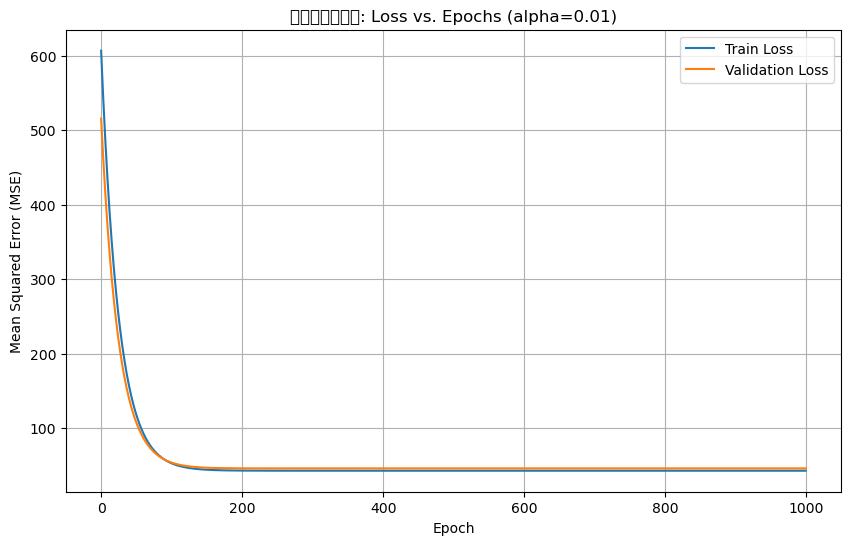

In [8]:
# --- 3.6 绘制 Loss 变化曲线 ---
plt.figure(figsize=(10, 6))
plt.plot(range(epochs), loss_history_train, label='Train Loss')
plt.plot(range(epochs), loss_history_val, label='Validation Loss')
plt.title('单变量梯度下降: Loss vs. Epochs (alpha=0.01)')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error (MSE)')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# --- 4. 多变量线性回归 (sklearn) ---

# 4.1 初始化并训练模型
# 我们使用标准化的数据 (不带手动添加的偏置列)
model_sklearn = LinearRegression()

# 训练模型
model_sklearn.fit(X_train_scaled, y_train)

# 4.2 在验证集上进行预测和评估
y_pred_val_sklearn = model_sklearn.predict(X_val_scaled)
mse_val_sklearn = mean_squared_error(y_val, y_pred_val_sklearn)

print(f"sklearn 多变量模型 验证集 MSE: {mse_val_sklearn:.4f}")

# --- 4.3 结果对比 ---
print("\n--- 最终模型性能对比 (验证集 MSE) ---")
print(f"1. 闭式解 (全部特征):   {loss_val:.4f}")
print(f"2. sklearn (全部特征):  {mse_val_sklearn:.4f}")
print(f"3. 手动GD (单个特征):   {loss_history_val[-1]:.4f}")

sklearn 多变量模型 验证集 MSE: 24.2911

--- 最终模型性能对比 (验证集 MSE) ---
1. 闭式解 (全部特征):   24.2911
2. sklearn (全部特征):  24.2911
3. 手动GD (单个特征):   46.1448


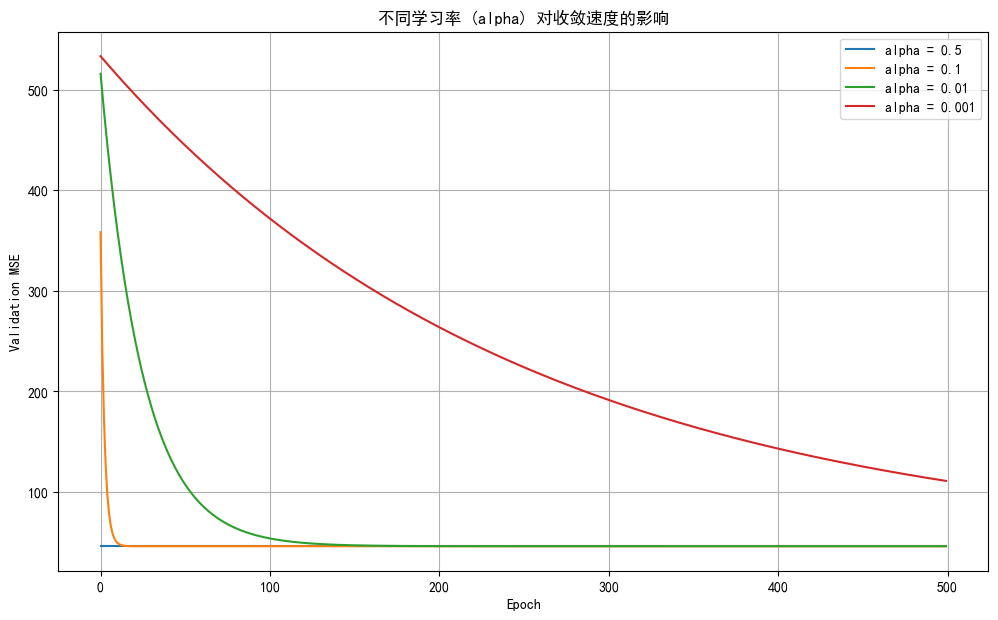

In [11]:
# --- 5. 参数分析 (学习率) ---

# 我们来测试几个不同的学习率
alphas_to_test = [0.5, 0.1, 0.01, 0.001]
epochs = 500 # 500次迭代足够观察趋势

plt.figure(figsize=(12, 7))

for alpha in alphas_to_test:
    # 重新初始化 w 和 b
    w = np.zeros((1, 1))
    b = np.zeros((1, 1))
    
    loss_history = [] # 只记录loss变化
    
    # 获取样本数 (之前定义过了, n_samples)
    
    for i in range(epochs):
        # --- 梯度下降 ---
        y_pred_train = X_train_rm @ w + b
        error = y_pred_train - y_train
        dw = (2 / n_samples) * (X_train_rm.T @ error)
        db = (2 / n_samples) * np.sum(error)
        w = w - alpha * dw
        b = b - alpha * db
        
        # --- 只记录验证集 Loss ---
        y_pred_val = X_val_rm @ w + b
        loss_history.append(mse_loss(y_val, y_pred_val))
    
    # 绘制当前 alpha 的曲线
    plt.plot(range(epochs), loss_history, label=f'alpha = {alpha}')

# --- 解决中文乱码问题 (可选, 但推荐) ---
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False # 解决负号'-'显示为方块的问题
# --- --------------------------------- ---

plt.title('不同学习率 (alpha) 对收敛速度的影响')
plt.xlabel('Epoch')
plt.ylabel('Validation MSE')
plt.legend()
plt.grid(True)
# 设置y轴范围，防止 "爆炸" 的曲线(如alpha=0.5) 影响观察
plt.show()